## MSDS 7331 - Case Study 5- Classifier to accept or deny receiving email
Daniel Crouthamel

Sophia Wu

Fabio Savorgnan

Bo Yun



In [73]:
#importing libraries and reading in file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from scipy.stats import randint as sp_randint

#general sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay

# Yellowbrick
from yellowbrick.model_selection import FeatureImportances

#Pipeline
from sklearn.pipeline import make_pipeline

# Files
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
from scipy.io import arff

# Introduction

In this study, we will be building a classifier to predict the email that will be accepted or denied

# Bussiness understanding

This company is receiving multiples email, and there is a necessity to automatize the acceptance and denial of the email request, therefore with the given dataset we will be building a model that automatically will accept and deny email. This process will allow the company to in a more efficient way utilize its resources, it seems now that the deny e mail is utilizing a lot of recourses that could be focus on the allow e mail. That way the company will be able to lower the overhead. 

# Data Engineering

We load the data which has 65532 and 12 columns including the target. We found that the dataset does not have any missing values. All the columns are numbers and are skew, please see the graph below. We will be using for our selected model svm, therefore, the skew shape of the data is not going to be a problem. The target values are multiclass. But it would make send due to the objective at hand to convert the multi class target to binary classification, which would be allow and deny. Therefore, the target values drop, and reset-both are being put together in the deny value for our binary classification. The final target class has 37640 allow and 27892 deny is mildly unbalanced but in our model with the balanced hyperparameter in the SGD will take care of the mildly unbalanced target. Finally we checked for missing values where we found no missing values, therefore there is not a necessity to impute any missing data. 

# Load the data

In [5]:
df = pd.read_csv('log2.csv')
df.head()

Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
0        57222                53            54587                    53   
1        56258              3389            56258                  3389   
2         6881             50321            43265                 50321   
3        50553              3389            50553                  3389   
4        50002               443            45848                   443   

  Action  Bytes  Bytes Sent  Bytes Received  Packets  Elapsed Time (sec)  \
0  allow    177          94              83        2                  30   
1  allow   4768        1600            3168       19                  17   
2  allow    238         118             120        2                1199   
3  allow   3327        1438            1889       15                  17   
4  allow  25358        6778           18580       31                  16   

   pkts_sent  pkts_received  
0          1              1  
1         10              9  
2          1              1  
3          8              7  
4         13             18

In [72]:
df.shape

(65532, 12)

# EDA

In [6]:
p = df.describe()
p

Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
count  65532.000000      65532.000000     65532.000000          65532.000000   
mean   49391.969343      10577.385812     19282.972761           2671.049930   
std    15255.712537      18466.027039     21970.689669           9739.162278   
min        0.000000          0.000000         0.000000              0.000000   
25%    49183.000000         80.000000         0.000000              0.000000   
50%    53776.500000        445.000000      8820.500000             53.000000   
75%    58638.000000      15000.000000     38366.250000            443.000000   
max    65534.000000      65535.000000     65535.000000          65535.000000   

              Bytes    Bytes Sent  Bytes Received       Packets  \
count  6.553200e+04  6.553200e+04    6.553200e+04  6.553200e+04   
mean   9.712395e+04  2.238580e+04    7.473815e+04  1.028660e+02   
std    5.618439e+06  3.828139e+06    2.463208e+06  5.133002e+03   
min    6.000000e+01  6.000000e+01    0.000000e+00  1.000000e+00   
25%    6.600000e+01  6.600000e+01    0.000000e+00  1.000000e+00   
50%    1.680000e+02  9.000000e+01    7.900000e+01  2.000000e+00   
75%    7.522500e+02  2.100000e+02    4.490000e+02  6.000000e+00   
max    1.269359e+09  9.484772e+08    3.208818e+08  1.036116e+06   

       Elapsed Time (sec)      pkts_sent  pkts_received  
count        65532.000000   65532.000000   65532.000000  
mean            65.833577      41.399530      61.466505  
std            302.461762    3218.871288    2223.332271  
min              0.000000       1.000000       0.000000  
25%              0.000000       1.000000       0.000000  
50%             15.000000       1.000000       1.000000  
75%             30.000000       3.000000       2.000000  
max          10824.000000  747520.000000  327208.000000

In [7]:
# Check for missing data
for i in df.columns:
    if i == "Action":
        continue
    if p.loc["count", i] != df.shape[0]:
        print (i)
print("No missing data")

No missing data


array([[<AxesSubplot:title={'center':'Source Port'}>,
        <AxesSubplot:title={'center':'Destination Port'}>,
        <AxesSubplot:title={'center':'NAT Source Port'}>],
       [<AxesSubplot:title={'center':'NAT Destination Port'}>,
        <AxesSubplot:title={'center':'Bytes'}>,
        <AxesSubplot:title={'center':'Bytes Sent'}>],
       [<AxesSubplot:title={'center':'Bytes Received'}>,
        <AxesSubplot:title={'center':'Packets'}>,
        <AxesSubplot:title={'center':'Elapsed Time (sec)'}>],
       [<AxesSubplot:title={'center':'pkts_sent'}>,
        <AxesSubplot:title={'center':'pkts_received'}>, <AxesSubplot:>]],
      dtype=object)

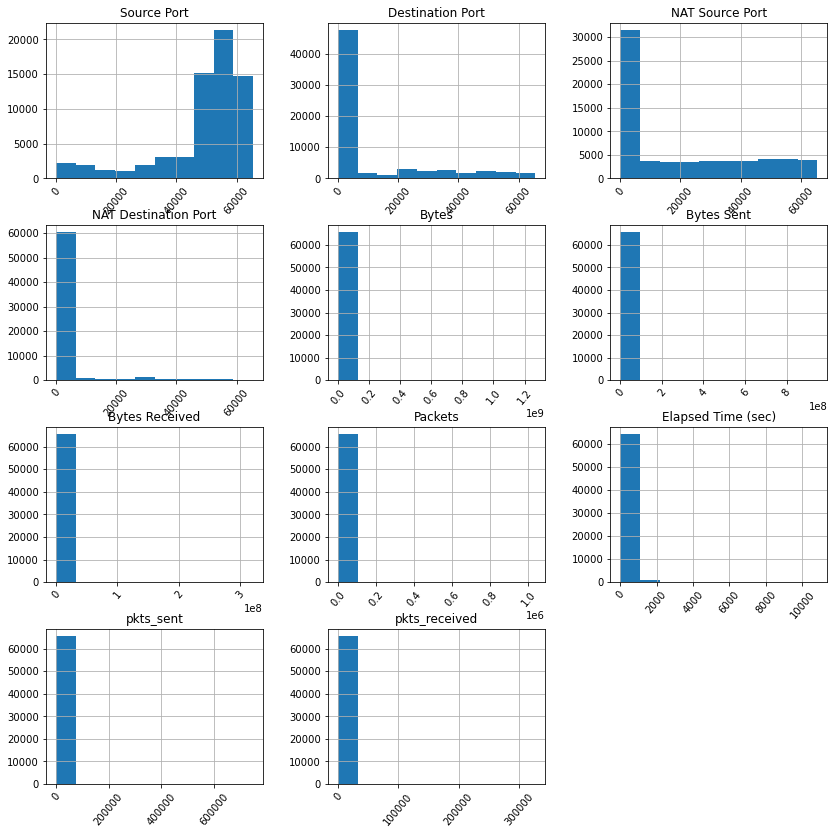

In [8]:
df.hist(figsize=(14,14), xrot=50)

# Explore the target

In [9]:
df["Action"].unique
# This show that the target is very inbalanced
df["Action"].value_counts(normalize=False)


allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

(array([37640.,     0.,     0., 12851.,     0.,     0., 14987.,     0.,
            0.,    54.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

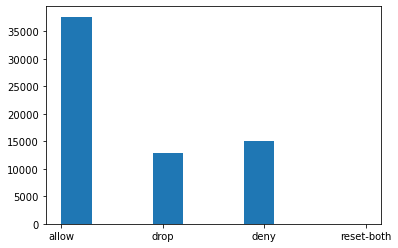

In [10]:
# Plot to better show the inbalanced target
plt.hist(df["Action"])

# We made the target binary

In [11]:
# Make the target binary
target= []

for i in df["Action"]:
    if i == "allow":
        target.append("Allow")
    if i == "deny":
        target.append("Deny")
    if i == "drop":
        target.append("Deny")
    if i == "reset-both":
        target.append("Deny")

df["target"]= target

In [71]:
df["target"].value_counts(normalize=False)

Allow    37640
Deny     27892
Name: target, dtype: int64

# Final detaset

In [12]:

df.drop(columns="Action", inplace= True)
df.head()

Source Port  Destination Port  NAT Source Port  NAT Destination Port  \
0        57222                53            54587                    53   
1        56258              3389            56258                  3389   
2         6881             50321            43265                 50321   
3        50553              3389            50553                  3389   
4        50002               443            45848                   443   

   Bytes  Bytes Sent  Bytes Received  Packets  Elapsed Time (sec)  pkts_sent  \
0    177          94              83        2                  30          1   
1   4768        1600            3168       19                  17         10   
2    238         118             120        2                1199          1   
3   3327        1438            1889       15                  17          8   
4  25358        6778           18580       31                  16         13   

   pkts_received target  
0              1  Allow  
1              9  Allow  
2              1  Allow  
3              7  Allow  
4             18  Allow

# Mdel preparetion

We will split our dataset in train and test with 70% train and 30% test. 

Then we will prepare our SVM model. We set up a grid search, in the gird search we will explore the best kernel and the best C hyperparameter.
Cfloat, default=1.0
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
kernel{‘linear’, ‘rbf}, default=’rbf’
Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).

The second model that we will use to compare with the SVM model is the SGD.
In the SGM classifier we decided to use the logistic regression classifier with a penalty of l2. Then we run a grid search to find the best alpha value. 


# SVM

In [13]:
# prepare test and train data

X = df.loc[:, df.columns != 'target'].values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [14]:
from sklearn.svm import SVC

param_grid= {'kernel': ('linear', 'rbf'),
            'C': [0.1, 1, 10, 100]}

base_estimator = SVC(gamma='scale')

grid_search = GridSearchCV(base_estimator, param_grid= param_grid)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
       % (time() - start, len(grid_search.cv_results_['params'])))


GridSearchCV took 4225.79 seconds for 8 candidate parameter settings.


# Number of support vectors

In [68]:
len(grid_search.best_estimator_.n_support_)

2

# Evaluation of the model

We decided that for the objective at hand the accuracy is the most important parameter to keep in mind. We want to make sure that we get it right.

The accuracy formula helps to know the errors in the measurement of values. If the measured value is equal to the actual value, then it is said to be highly accurate and with low errors. Accuracy and error rate are inversely related. High accuracy refers to low error rate, and high error rate refers to low accuracy. The accuracy formula gives the accuracy as a percentage value, and the sum of accuracy and error rate is equal to 100 percent. Therefore, the accuracy will be the evaluating measure for selection of our model.

We decided that for the objective at hand the accuracy is the most important parameter to keep in mind. We want to make sure that we get it right.

The accuracy formula helps to know the errors in the measurement of values. If the measured value is equal to the actual value, then it is said to be highly accurate and with low errors. Accuracy and error rate are inversely related. High accuracy refers to low error rate, and high error rate refers to low accuracy. The accuracy formula gives the accuracy as a percentage value, and the sum of accuracy and error rate is equal to 100 percent. Therefore, the accuracy will be the evaluating measure for selection of our model.

We decided to select the svm model with an accuracy of 99.7%. There are only 55 misclassifications from 21626 classification target. For completeness the recall is 99.6% and the precision is 99.5%. The best hyperparameters were the linear kernel and the penalty of 1. 
The feature that contributes the most for this svm classifier were ‘Elapsed Time’, ‘Packets’ and ‘pkts_sent’. This model builds 2 support vectors as the classification boundary. 

The competing model has high accuracy and recall also, please see the code, accuracy 99.3% recall 99.6% and precision 99.5%. The best hyperparameters used in this competing model were 'alpha': 0.01, 'loss': 'log', 'penalty': 'l2'. The most important feature in this model were ‘Bytes received’, ‘Bytes’, ‘Elapsed Time’ as the previous selected model. 




# Evaluation of the svm model

In [15]:
y_hat_rf_train = grid_search.predict(X_train)
accuracy_score(y_hat_rf_train, y_train)

0.9975174235867535

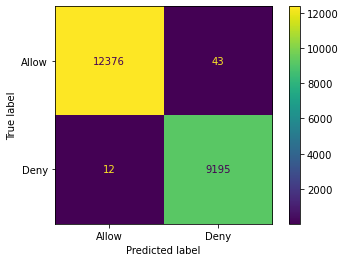

In [35]:
# Confusion matrix train
confusion_matrix(y_train, y_hat_rf_train)
disp = ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test)

In [36]:
y_hat_rf_test = grid_search.predict(X_test)
accuracy_score(y_hat_rf_test, y_test)

0.9974567650050865

In [37]:
# Precision and recall
print("Recall:", recall_score(y_test, y_hat_rf_test, pos_label="Allow", average='binary'))
print("Precision:", precision_score(y_test, y_hat_rf_test, pos_label="Deny", average='binary'))

Recall: 0.9965375634109026
Precision: 0.9953453128382767


# Plot

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Precision-Recall Curve')

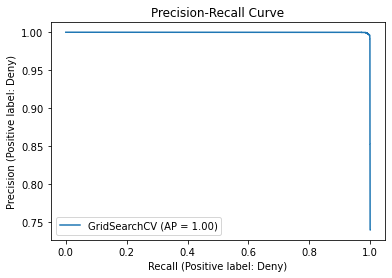

In [38]:
disp = plot_precision_recall_curve(grid_search, X_test, y_test,)
disp.ax_.set_title('Precision-Recall Curve')

# ROC

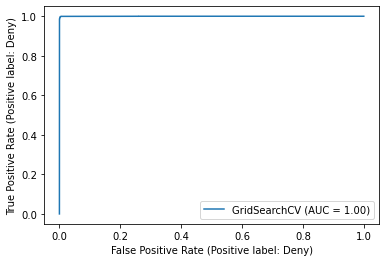

In [39]:
Disp = RocCurveDisplay.from_estimator(grid_search, X_test, y_test)

# Evaluation of the hyperparameters

In [26]:
p=  ['linear', 'rbf']

for i in p:
    model = SVC(kernel= i)
    model.fit(X_train, y_train)
    y_hat_rf_test = model.predict(X_test)
    print(accuracy_score(y_hat_rf_test, y_test)) 



0.9974567650050865
0.6335429575510959


In [32]:
C= [0.1, 1, 10]

for i in C:
    model = SVC(C= i)
    model.fit(X_train, y_train)
    y_hat_rf_test = model.predict(X_test)
    print(accuracy_score(y_hat_rf_test, y_test)) 

0.5742624618514751
0.6335429575510959
0.8671044113567002


# Best hyperparams after the gridsearch evaluated above

In [28]:
grid_search.best_params_


{'C': 1, 'kernel': 'linear'}

# Feature importance

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


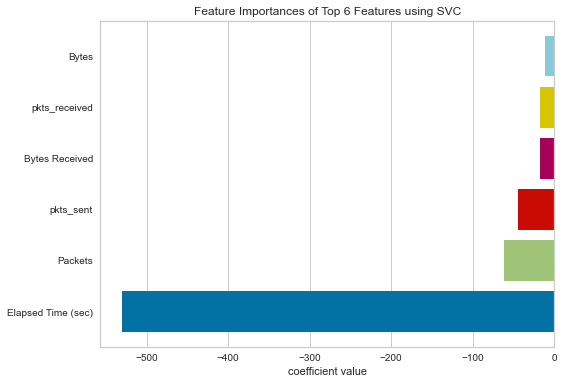

<AxesSubplot:title={'center':'Feature Importances of Top 6 Features using SVC'}, xlabel='coefficient value'>

In [63]:
best= grid_search.best_estimator_
viz = FeatureImportances(best, topn=6, relative=False, labels=df.columns.to_list())
viz.fit(X_test, y_test)
viz.show()

# SGD

In [41]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

param_grid = {
    'loss': ['log'],
    'penalty': ['l2'],
    'alpha': [10 ** x for x in range(-3, 1)],
}
clf = SGDClassifier(random_state=0, class_weight='balanced', max_iter=100)

clf_grid = GridSearchCV(estimator=clf, param_grid=param_grid,
                                    n_jobs=-1, scoring='accuracy')

clf_grid.fit(X_train, y_train)
y_hat_rf_train = clf_grid.predict(X_train)
accuracy_score(y_hat_rf_train, y_train)

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:707: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


0.9935088598369244

# SGD best parameter

In [46]:
clf_grid.best_params_

{'alpha': 0.01, 'loss': 'log', 'penalty': 'l2'}

# Evaluation of the SGD model

In [42]:
y_hat_rf_train = clf_grid.predict(X_train)
accuracy_score(y_hat_rf_train, y_train)

0.9935088598369244

In [43]:
# Precision and recall
print("Recall:", recall_score(y_test, y_hat_rf_test, pos_label="Allow", average='binary'))
print("Precision:", precision_score(y_test, y_hat_rf_test, pos_label="Deny", average='binary'))

Recall: 0.9965375634109026
Precision: 0.9953453128382767


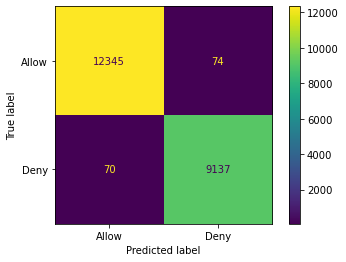

In [47]:
disp = ConfusionMatrixDisplay.from_estimator(clf_grid, X_test, y_test)

# Plot precision and recall

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Precision-Recall Curve')

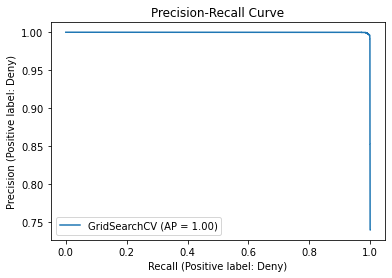

In [44]:
disp = plot_precision_recall_curve(grid_search, X_test, y_test,)
disp.ax_.set_title('Precision-Recall Curve')

# AUC

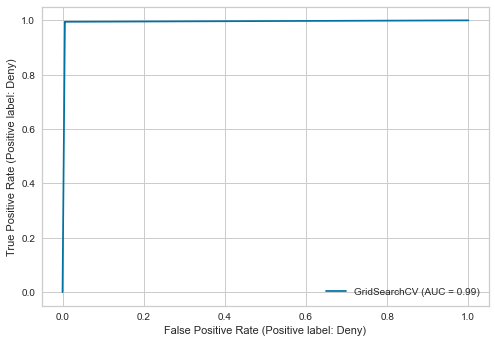

In [57]:
Disp = RocCurveDisplay.from_estimator(clf_grid, X_test, y_test)

# Feature importance

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


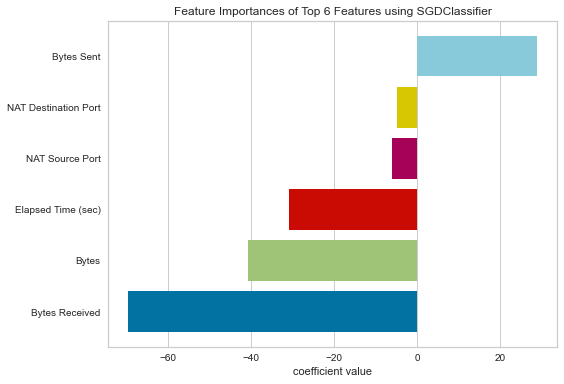

<AxesSubplot:title={'center':'Feature Importances of Top 6 Features using SGDClassifier'}, xlabel='coefficient value'>

In [62]:
best= clf_grid.best_estimator_
viz = FeatureImportances(best, topn=6, relative=False, labels=df.columns.to_list())
viz.fit(X_test, y_test)
viz.show()